In [2]:
import numpy as np, matplotlib.pyplot as plt, glob, os, itertools, \
    skimage.segmentation as segm, networkx as nx, simplification.cutil as simpl, \
    scipy.ndimage as ndimage, matplotlib.colors as mplcol, matplotlib.cm as cm
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm_notebook as tqdm
import shapely.ops, shapely.geometry as geom
from skimage.measure import label

#### Set color scheme

In [3]:
COLORS = [
    (0, 0, 0),
    (230, 159, 0),
#    (86, 180, 233),
    (0, 158, 115),
#    (240, 228, 66),
    (0, 114, 178),
#    (213, 94, 0),
    (204, 121, 167),
    
    (0, 0, 0),
    (0, 0, 0),
    (0, 0, 0),
    (0, 0, 0),
    (0, 0, 0),
    (0, 0, 0),
    (0, 0, 0),
    (0, 0, 0),
    (0, 0, 0),
    (0, 0, 0),
    (0, 0, 0),
    (0, 0, 0),
    (0, 0, 0),
    (0, 0, 0),
]
COLORS = [mplcol.rgb2hex(np.array(x) / 255.0) for x in COLORS]

### Specify data files to display

##### Option 1: Shared embedding

In [156]:
fnameP = 'Y:/wavelet/wavelet_dlc_euclidean-midline_no-abspos_no-vel_00000000010001000000010001_1_20/'
fnameP+= 'wavelet_dlc_euclidean-midline_no-abspos_no-vel_00000000010001000000010001_1_20_hipow_tsne_no-pca_perplexity_100_200000_2000_euclidean.npy'
fnameP = '\\\\?\\' + fnameP.replace('/', '\\')

fnameA = 'Y:/wavelet/wavelet_dlc_euclidean_no-abspos_no-vel_00000010001000000010001000_1_20/'
fnameA+= 'wavelet_dlc_euclidean_no-abspos_no-vel_00000010001000000010001000_1_20_hipow_tsne_no-pca_perplexity_100_200000_2000_euclidean.npy'
fnameA = '\\\\?\\' + fnameA.replace('/', '\\')

fnames = [fnameP, fnameA]

#### Option 2: Single-recording embedding, split A/P

In [5]:
fnameP = 'Z:/behavior/6-23-19-e/embeddings/wavelet_dlc_euclidean-midline_no-abspos_no-vel_00000000010001000000010001_1_20/'
fnameP+= 'wavelet_dlc_euclidean-midline_no-abspos_no-vel_00000000010001000000010001_1_20_hipow_tsne_no-pca_perplexity_100_200000_2000_euclidean.npy'
fnameP = '\\\\?\\' + fnameP.replace('/', '\\')

fnameA = 'Z:/behavior/6-23-19-e/embeddings/wavelet_dlc_euclidean_no-abspos_no-vel_00000010001000000010001000_1_20/'
fnameA+= 'wavelet_dlc_euclidean_no-abspos_no-vel_00000010001000000010001000_1_20_hipow_tsne_no-pca_perplexity_100_200000_2000_euclidean.npy'
fnameA = '\\\\?\\' + fnameA.replace('/', '\\')

fnames = [fnameP, fnameA]

#### Option 3: Single-recording embedding, combined A/P

In [5]:
fnameAP = 'Z:/behavior/6-23-19-e/embeddings/wavelet_dlc_euclidean_no-abspos_no-vel_00000010011001000010011001_1_20/'
fnameAP+= 'wavelet_dlc_euclidean_no-abspos_no-vel_00000010011001000010011001_1_20_hipow_tsne_no-pca_perplexity_100_200000_2000_euclidean.npy'
fnameAP = '\\\\?\\' + fnameAP.replace('/', '\\')

fnames = [fnameAP, ]

##### Compute densities

In [6]:
Hs = []
arrs = []

for fname in fnames:
    if fname is None:
        Hs.append(None)
        arrs.append(None)
    else:
        arr = np.load(fname).copy()
        arr = arr[~np.any(np.isnan(arr), axis=1)]
        H, _, _ = np.histogram2d(arr[:,0], arr[:,1], bins=(200,200))
        H = np.clip(H, 0, np.percentile(H, 99))

        arrs.append(arr)
        Hs.append(H)

##### Load corresponding watershed files

In [11]:
fnamesWatershed = [x.replace('.npy', '.smoothed.watershed.npy') for x in fnames]
fnamesWatershed = [(x if os.path.exists(x) else None) for x in fnamesWatershed]
fnamesWatershed

['\\\\?\\Z:\\behavior\\6-23-19-e\\embeddings\\wavelet_dlc_euclidean_no-abspos_no-vel_00000010011001000010011001_1_20\\wavelet_dlc_euclidean_no-abspos_no-vel_00000010011001000010011001_1_20_hipow_tsne_no-pca_perplexity_100_200000_2000_euclidean.smoothed.watershed.npy']

In [12]:
arrWatershed = [np.load(x) for x in fnamesWatershed]

##### Load cluster and xy position data

In [14]:
RECORDINGS = ['6-23-19-e', '4-5-19-a']
if '\\embeddings\\' in fnames[0]:
    RECORDINGS = ['6-23-19-e', ]

# Find the cluster ID data
arrClustersAll = [[np.load('\\\\?\\Z:\\behavior\\{}\\{}\\{}'.format(
    RECORDING, 'wavelet' if not 'embeddings' in fnames[0] else 'embeddings', 
        os.path.basename(fnames[fnameIdx]).replace('.npy', '.clusters.npy')))[:,0].astype(int) \
            for RECORDING in RECORDINGS] for fnameIdx in range(len(fnames))]

# Load the position data
fnamePos = [glob.glob('\\\\?\\Z:\\behavior\\{}\\croprot\\*_dlc_abs_filt_interp_mvmt_noborder.npy'.format(
    RECORDING))[0] for RECORDING in RECORDINGS]
xy = [np.mean(np.load(fn)[:, [0,1], 0:2], axis=1) for fn in fnamePos]

##### Helper functions

In [17]:
# Based on: https://stackoverflow.com/questions/37742358/sorting-points-to-form-a-continuous-line
"""
def maskToPerimeter(mask):
    mask[0,:] = False
    mask[-1,:] = False
    mask[:,0] = False
    mask[:,-1] = False
    
    try:
        pts = np.argwhere(segm.find_boundaries(mask, mode='inner'))
        pts = pts[list(nx.dfs_preorder_nodes(nx.from_scipy_sparse_matrix(
            NearestNeighbors(2).fit(pts).kneighbors_graph()), 0)),:]
        pts = np.vstack((pts, pts[-1,:]))
        return pts
    except:
        return None
""";

def maskToPerimeter(mask):
    mask[0,:] = False
    mask[-1,:] = False
    mask[:,0] = False
    mask[:,-1] = False
    
    polys = [geom.Polygon([[_x + dx, _y + dy] for dx, dy in [[0,0],[0,1],[1,1],[1,0]]]) for _x, _y in \
         np.argwhere(mask)]
    a = shapely.ops.cascaded_union(polys).exterior.coords.xy
    xy = np.hstack((np.array(a[0])[:,np.newaxis], np.array(a[1])[:,np.newaxis]))
    
    return xy

In [18]:
def simplifyScatter(_pts, thresh = 2):
    if _pts.shape[0] < 1000:
        return _pts
    pts = _pts.copy()
    mindst = 0
    with tqdm(np.arange(10000), leave=False) as pbar:
        for i in pbar:
            if mindst < thresh:
                nn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(pts)
                dsts = nn.kneighbors()[0][:,0]
                mindst = np.min(dsts)
                idxSS = np.full(pts.shape[0], True, dtype=np.bool)
                idxSS[np.argsort(dsts)[0:int(np.ceil(dsts.shape[0] * 0.02)):2]] = False
                pts = pts[idxSS]
                pbar.set_description('{} {}'.format(pts.shape[0], mindst))
            pbar.update()
    return pts

In [19]:
from skimage.measure import label

In [20]:
import colorcet
import matplotlib.colors
import matplotlib.cm as cm

class customColormap(matplotlib.colors.LinearSegmentedColormap):
    def __init__(self, *args, **kwargs):
        self.baseCM = cm.get_cmap('cet_CET_L17')
        self.N = self.baseCM.N
    def __call__(self, r, *args, **kwargs):
        def mapColor(x):
            _c = self.baseCM(0.0, *args, **kwargs)
            lim = 0.10
            if x >= lim:
                return self.baseCM((x-lim)/(1.0 - lim), *args, **kwargs)
            else: 
                if isinstance(_c[0], float):
                    z = (x / 0.05)
                    a = _c[0] * z + 1.0 * (1 - z)
                    b = _c[1] * z + 1.0 * (1 - z)
                    c = _c[2] * z + 1.0 * (1 - z)
                    _c = (a, b, c, 1.0)
                    return _c
                else:
                    z = (x / lim)
                    a = int(_c[0] * z + 255.0 * (1 - z))
                    b = int(_c[1] * z + 255.0 * (1 - z))
                    c = int(_c[2] * z + 255.0 * (1 - z))
                    _c = (a, b, c, 255)
                    return _c
        if r.ndim == 2:
            _c = self.baseCM(0.0, *args, **kwargs)
            cs = np.array([[mapColor(y) for y in x] for x in r], 
                dtype=np.float64 if isinstance(_c[0], float) else np.uint8)
            return cs
        elif r.ndim == 1:
            _c = self.baseCM(0.0, *args, **kwargs)
            cs = np.array([mapColor(y) for y in r], 
                dtype=np.float64 if isinstance(_c[0], float) else np.uint8)
            return cs
        else:
            print('!!')

In [21]:
_cm = customColormap()

def plotColumn(ax, clusterIDs, fnameIdx, RECORDINGS = RECORDINGS, scatterSimplify = 1, dbg=None, 
               eventColor = '#222222', clusterColor = '#009e73'):
    # ---------------------------------------------------------------------------
    # Plot density
    # ---------------------------------------------------------------------------

    # Get image
    imgDensity = np.clip(arrWatershed[fnameIdx][:,:,0,0], 0, 
        np.percentile(arrWatershed[fnameIdx][:,:,0,0], 99))

    # Plot density
    ax[0].imshow(Hs[fnameIdx], cmap=_cm)

    # Plot clusters to highlight
    mask = None
    for exID, clusterID in enumerate(clusterIDs):
        _mask = (arrWatershed[fnameIdx][:,:,0,1] == clusterID)
        # Merge masks
        mask = _mask if mask is None else (mask | _mask)
        
    # Split masks into contiguous submasks
    maskLabeled = label(mask)
    maskLabeledBg = np.max([np.sum(maskLabeled == x) for x in np.unique(maskLabeled)])
    for maskID in np.unique(maskLabeled):
        if np.sum(maskLabeled == maskID) != maskLabeledBg:
            mask = (maskLabeled == maskID)
            #mask[:25,:] = False
            #mask[175:,:] = False
            #mask[:,:25] = False
            #mask[:,175:] = False
            mask = ndimage.binary_dilation(ndimage.binary_erosion(mask, iterations=1), iterations=1)
            pts = maskToPerimeter(mask)
            if pts is not None:
                ax[0].plot(pts[:,1], pts[:,0], color=clusterColor, linewidth=2)

    # Finish first subplot
    ax[0].set_xlim(25, 175)
    ax[0].set_ylim(25, 175)
    ax[0].set_axis_off()

    # ---------------------------------------------------------------------------
    # Plot occurrence locations
    # ---------------------------------------------------------------------------
    
    arrClusters = arrClustersAll[fnameIdx].copy()

    for fID in range(len(fnamePos)):
        resVW_w = 250
        ax1 = ax[2 + fID]

        xySimpl = simpl.simplify_coords_vw(xy[fID], resVW_w)
        segmentIDs = np.cumsum(np.linalg.norm(xySimpl - np.roll(xySimpl, 1, axis=0), axis=1) > 200)

        for sid in np.unique(segmentIDs):
            ax1.plot(xySimpl[segmentIDs==sid, 0], xySimpl[segmentIDs==sid, 1], 
                     color='black', linewidth=0.3)

        # Plot event occurrences
        idxOcc = ndimage.binary_dilation(ndimage.binary_erosion(
            np.isin(arrClusters[fID], clusterIDs), iterations=12), iterations=12)[:xy[fID].shape[0]]
        idxOcc = np.hstack((np.full(xy[fID].shape[0] - idxOcc.shape[0], False, dtype=np.bool), idxOcc))
        pts = simplifyScatter(xy[fID][idxOcc, :], scatterSimplify)
        ax1.scatter(pts[:,0], pts[:,1], s=1.4, 
                    color=COLORS[exID + 2] if eventColor is None else eventColor, zorder=10)
        if dbg is not None:
            dbg.append((xy[fID][idxOcc, :].copy()))

        # Resize web to smallest square
        xyMin = np.min(xySimpl, axis=0)
        xyMax = np.max(xySimpl, axis=0)
        xyWidth  = xyMax[0] - xyMin[0]
        xyHeight = xyMax[1] - xyMin[1]
        xyCent = xyMin * 0.5 + xyMax * 0.5
        xySpan = max(xyWidth, xyHeight) / 2
        ax1.set_xlim(xyCent[0] - xySpan, xyCent[0] + xySpan)
        ax1.set_ylim(xyCent[1] - xySpan, xyCent[1] + xySpan)
        ax1.set_axis_off()

### Plot movement visualization

In [22]:
def plotFrame(d, fidx, ax, jointcolor='#000000', segmentcolor='#000000', zorder=10, limbTrace=None):
    # Draw body joints
    for i in [5, 9, 13, 17, 21, 25, 2, 6, 10, 14, 18, 22]: #range(26):
        _x = d[fidx, i,0]
        _y = d[fidx, i,1]
        if not np.isnan(_x) and not np.isnan(_y):
            if jointcolor is not None or limbTrace==i:
                if limbTrace != i:
                    ax.scatter(_x, _y, c=jointcolor, s=8)
                    #ax.text(_x, _y, i, fontsize=12, color=jointcolor)
                else:
                    ax.scatter(_x, _y, c='#ff5555', s=350, marker='*')
                
    def _plot(x, y, c):
        if not np.isnan(x[0]) and \
            not np.isnan(x[1]) and \
            not np.isnan(y[0]) and \
            not np.isnan(y[1]):
            ax.plot(x, y, c, zorder=zorder)

    # Draw body segments
    def _p(i, j): return [
        (d[fidx, i, 0], d[fidx, j, 0]), 
        (d[fidx, i, 1], d[fidx, j, 1]), segmentcolor]

    _plot( *_p(14,18) ); _plot( *_p(18,22) )
    _plot( *_p( 2, 6) ); _plot( *_p( 6,10) )

    #_plot( *_p(15,19) ); _plot( *_p(19,23) )
    #_plot( *_p( 3, 7) ); _plot( *_p( 7,11) )

    #_plot( *_p(16,20) ); _plot( *_p(20,24) )
    #_plot( *_p( 4, 8) ); _plot( *_p( 8,12) )

    _plot( *_p(17,21) ); _plot( *_p(21,25) )
    _plot( *_p( 5, 9) ); _plot( *_p( 9,13) )
    
    # Set bounding box for display
    plt.xlim(-75, 75)
    plt.ylim(-75, 75)
    
def plotMovement(ax, recID, fnameIdx, clusterID, eventIdx, limbTrace = None):
    limbsToPlot = [5, 9, 13, 17, 21, 25] if fnameIdx == 0 else [2, 6, 10, 14, 18, 22]

    idxEvent = np.argwhere(arrClustersAll[fnameIdx][recID] == clusterID)[eventIdx,0]
    xyMov = np.load(fnamePos[recID])[(idxEvent-25):(idxEvent+25),:, 0:2]
    xyMov = xyMov - np.mean(xyMov[:,[0,1],:], axis=1)[:,np.newaxis,:]

    for i in range(0, 50, 2):
        # Decide what to plot
        _xyMov = xyMov.copy()
        for j in range(26):
            if j not in limbsToPlot:
                if i > 0:
                    _xyMov[:,j,:] = np.nan

        # Color
        c = mplcol.rgb2hex(cm.get_cmap('gray')(i * 0.02))
        jc = None
        if i == 0:
            c = 'red'
            jc = 'red'
        elif i == 48:
            c = 'blue'

        # Plot skeleton
        plotFrame(_xyMov, i, ax, jointcolor = jc, 
            segmentcolor = c, zorder=(10 if i == 0 else 0), limbTrace=limbTrace if i == 0 else None)

    ax.set_axis_off()
    ax.set_xlim(-60, 60)
    ax.set_ylim(-60, 60)
    
    if limbTrace is not None:
        ax.plot(np.linspace(-50, 50, 50), 
                _xyMov[:,limbTrace,0] - np.mean(_xyMov[:,limbTrace,0]) + 50)
        ax.plot(np.linspace(-50, 50, 50), 
                _xyMov[:,limbTrace,1] - np.mean(_xyMov[:,limbTrace,1]) + 40)

### Compose figure

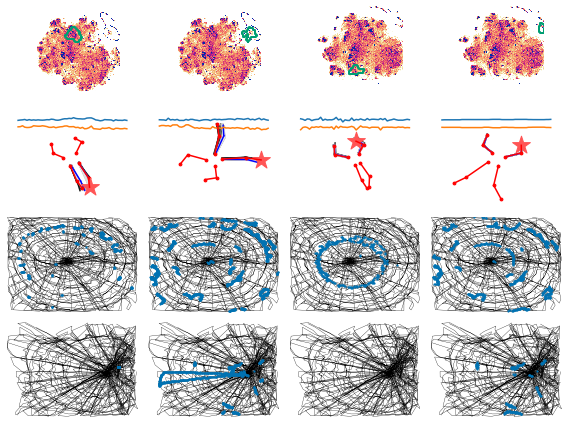

In [168]:
# Create figure
fig, ax = plt.subplots(2 + len(xy), 4, figsize=(8, (1 + len(xy)) * 2))

plotMovement(ax[1, 0], recID = 0, fnameIdx = 1, clusterID = 128, eventIdx = 50, limbTrace = 10)
plotMovement(ax[1, 1], recID = 1, fnameIdx = 1, clusterID = 123, eventIdx = 50, limbTrace = 22)
plotMovement(ax[1, 2], recID = 0, fnameIdx = 0, clusterID = 11 , eventIdx = 50, limbTrace = 13)
plotMovement(ax[1, 3], recID = 1, fnameIdx = 0, clusterID = 122, eventIdx = 50, limbTrace = 13)

# Plot columns
plotColumn(ax[:,0], clusterIDs = [128, 127, ], fnameIdx = 1, 
           RECORDINGS = RECORDINGS, scatterSimplify=1.7, eventColor=COLORS[3])
plotColumn(ax[:,1], clusterIDs = [114, 123, 124], fnameIdx = 1, 
           RECORDINGS = RECORDINGS, scatterSimplify=1.7, eventColor=COLORS[3])
plotColumn(ax[:,2], clusterIDs = [11, ], fnameIdx = 0, 
           RECORDINGS = RECORDINGS, scatterSimplify=4, eventColor=COLORS[3])
plotColumn(ax[:,3], clusterIDs = [119, 122], fnameIdx = 0, 
           RECORDINGS = RECORDINGS, scatterSimplify=2.5, eventColor=COLORS[3])

# Layout
fig.tight_layout()
fig.savefig('C:/Users/acorver/Desktop/paper-figures/Fig_suppl_2d.pdf', dpi=700)

### Compose single-recording figure (split A/P)

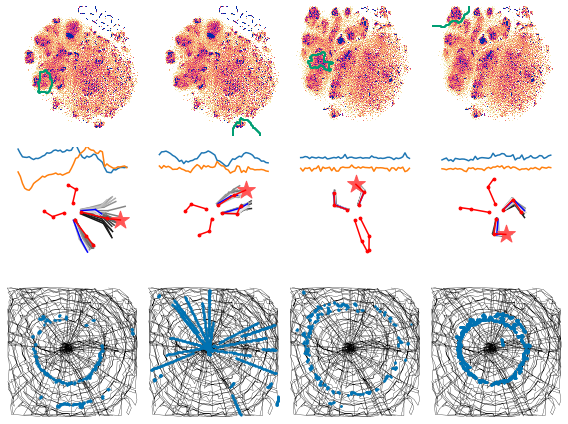

In [155]:
# Create figure
fig, ax = plt.subplots(3, 4, figsize=(8, 6))

plotMovement(ax[1, 0], recID = 0, fnameIdx = 1, clusterID = 150, eventIdx = 100, limbTrace = 10)
plotMovement(ax[1, 1], recID = 0, fnameIdx = 1, clusterID = 3, eventIdx = 100, limbTrace = 10)
plotMovement(ax[1, 2], recID = 0, fnameIdx = 0, clusterID = 193 , eventIdx = 200, limbTrace = 13)
plotMovement(ax[1, 3], recID = 0, fnameIdx = 0, clusterID = 301, eventIdx = 100, limbTrace = 13)

# Plot columns
plotColumn(ax[:,0], clusterIDs = [108,150], fnameIdx = 1, 
           RECORDINGS = RECORDINGS, scatterSimplify=2, eventColor=COLORS[3])
plotColumn(ax[:,1], clusterIDs = [2, 3], fnameIdx = 1, 
           RECORDINGS = RECORDINGS, scatterSimplify=1, eventColor=COLORS[3])
plotColumn(ax[:,2], clusterIDs = [193,], fnameIdx = 0, 
           RECORDINGS = RECORDINGS, scatterSimplify=2, eventColor=COLORS[3])
plotColumn(ax[:,3], clusterIDs = [301, 303, 304, 308, 309], fnameIdx = 0, 
           RECORDINGS = RECORDINGS, scatterSimplify=1, eventColor=COLORS[3])

# Layout
fig.tight_layout()
fig.savefig('C:/Users/acorver/Desktop/paper-figures/Fig_suppl_2d_singlerec.pdf', dpi=700)

### Compose single-recording figure (combined A/P)

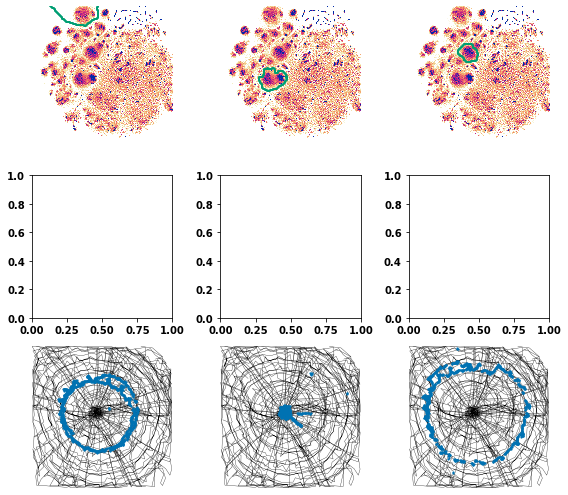

In [31]:
# Create figure
fig, ax = plt.subplots(3, 3, figsize=(8, 7))

# Plot columns
plotColumn(ax[:,0], clusterIDs = [344, 352, 358, 360], fnameIdx = 0, 
           RECORDINGS = RECORDINGS, scatterSimplify=2, eventColor=COLORS[3])
plotColumn(ax[:,1], clusterIDs = [160, 164, 168, 178, 186], fnameIdx = 0, 
           RECORDINGS = RECORDINGS, scatterSimplify=2, eventColor=COLORS[3])
plotColumn(ax[:,2], clusterIDs = [266,], fnameIdx = 0, 
           RECORDINGS = RECORDINGS, scatterSimplify=2, eventColor=COLORS[3])

# Layout
fig.tight_layout()
fig.savefig('C:/Users/acorver/Desktop/paper-figures/Fig_suppl_2C-P.pdf', dpi=700)